# WEEK 4b: Notes
***
***
**Table Of Content:**
- [WEEK 4b: Notes](#WEEK-4b:-Notes)
- [Data Classification with Python](#Data-Classification-with-Python)
- [Automate ML with PyCaret](#Automate-ML-with-PyCaret)
- [Clustering with Python](#Clustering-with-Python)
***
***

> Run the file on google-colab due to some on-machine conflicts

# Data Classification with Python

In [1]:
!pip install imblearn

In [2]:
!pip install pydotplus

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# ----------
# SMOTE is an oversampling technique.
# Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
# ----------

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# ----------
# To visualize the D-Tree
from sklearn.tree import export_graphviz
# ----------


# ----------
# PyDotPlus is an improved version of the old pydot project
# that provides a Python Interface to Graphviz's Dot language
import pydotplus
# ----------

from sklearn.metrics import classification_report

In [4]:
# Downloading the data
# 1) app_df has application data
# 2) cr_df has the credit status

app_df = pd.read_csv('https://drive.google.com/uc?id=1gjfTNwapOwg80NlUUkaW4bM9ffqLdtLk')
cr_df = pd.read_csv('https://drive.google.com/uc?id=1tF78o9Qcfc9IScQF1uxMAc3bS9c7SLbN')

In [5]:
app_df.head(2)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


In [8]:
cr_df.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [9]:
cr_df.shape

(1048575, 3)

- Preparing the target variable
1. For customers having due for multiple months, max number of months due is taken
1. Any ID with $\ge$ 1 month due is marked as class $1$

In [10]:
cr_df.MONTHS_BALANCE.value_counts()

-1     34436
-2     34209
 0     33856
-3     33854
-4     33365
       ...  
-56     2109
-57     1649
-58     1255
-59      820
-60      415
Name: MONTHS_BALANCE, Length: 61, dtype: int64

In [13]:
cr_df = cr_df.sort_values(
    ['ID', 'MONTHS_BALANCE'],
    ascending=False)
cr_df = cr_df.groupby('ID').max().reset_index()

In [14]:
cr_df.head(4)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001712,0,C
2,5001713,0,X
3,5001714,0,X


In [18]:
sorted(cr_df['STATUS'].unique())

['0', '1', '2', '3', '4', '5', 'C', 'X']

- C: Paid off that month
- X: No load for the month
- Status:
    - 0: 1-29 days past due
    - 1: 30-59 days past due
    - 2: 60-80 days past due
    - 3: 90-119 days past due
    - 4: 120-149 days past due
    - 5: Overdue or bad dept for more than 150 days

In [16]:
cr_df.STATUS.value_counts()

X    25005
C    14882
0     5161
1      821
5       54
2       49
3       10
4        3
Name: STATUS, dtype: int64

In [17]:
cr_df.shape

# From (1048575, 3)
# to (45985, 3)

(45985, 3)

In [19]:
cr_df['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
cr_df['STATUS'] = cr_df['STATUS'].astype('int')
cr_df['STATUS'] = cr_df['STATUS'].apply(lambda x:1 if x > 0 else 0)
cr_df['STATUS'].value_counts()


0    45048
1      937
Name: STATUS, dtype: int64

In [20]:
# Merging both application and credid status datasets

df = app_df.join(cr_df.set_index('ID'), on='ID', how='inner')
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 434812
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
MONTHS_BALANCE             0
STATUS                     0
dtype: int64

In [21]:
df['STATUS'].value_counts()

0    35689
1      768
Name: STATUS, dtype: int64

In [22]:
df.head(4)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0


In [23]:
binary_features = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_WORK_PHONE','FLAG_EMAIL']
continous_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']
cat_features = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']

In [24]:
# Occupation type has a lot of missing values
# We'll drop the entire column

df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [25]:
df['FLAG_MOBIL'].unique()

array([1])

In [ ]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [26]:
df.drop(['MONTHS_BALANCE', 'FLAG_MOBIL'], axis=1, inplace=True)


In [27]:
# Handling categorical features
from sklearn.preprocessing import OneHotEncoder

ohe = OrdinalEncoder(
    categories=[
        ['Student',
         'Pensioner',
         'Working',
         'Commercial associate',
         'State servant']
    ])


df.NAME_INCOME_TYPE = ohe.fit_transform(df.NAME_INCOME_TYPE.values.reshape(-1, 1))

df['NAME_INCOME_TYPE'].unique()

array([2., 3., 1., 4., 0.])

In [28]:
# Encoding ordinal columns without ordering

le = LabelEncoder()
cat_features = ['NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
for i in cat_features:
  df[i] = le.fit_transform(df[i].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# Pd dummies for OHE
#Getting dummies using Pandas
df = pd.get_dummies(df, columns=binary_features, drop_first=True)

In [30]:
df.head(2)

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_PHONE,CNT_FAM_MEMBERS,STATUS,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_WORK_PHONE_1,FLAG_EMAIL_1
0,5008804,0,427500.0,2.0,1,0,4,-12005,-4542,0,2.0,0,1,1,1,1,0
1,5008805,0,427500.0,2.0,1,0,4,-12005,-4542,0,2.0,0,1,1,1,1,0


<Axes: xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

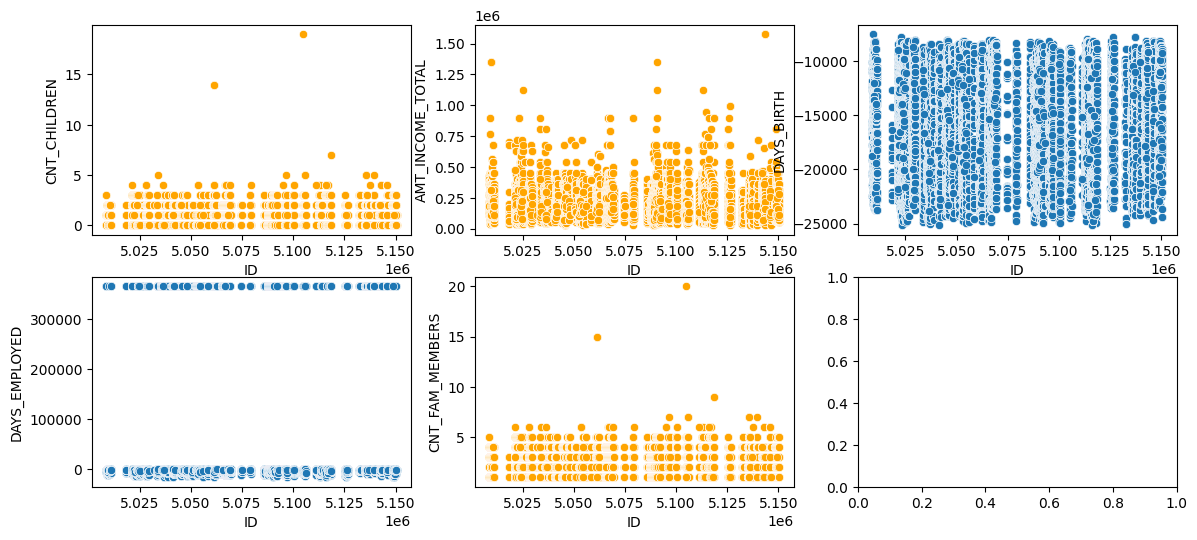

In [31]:
# Plotting different Variables
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df, ax=ax[1][0])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df, ax=ax[1][1], color= 'orange')

In [32]:
q_hi = df['AMT_INCOME_TOTAL'].quantile(0.75)
q_low = df['AMT_INCOME_TOTAL'].quantile(0.25)
IQR = q_hi - q_low
lower_range = q_low - (1.5 * IQR)
upper_range = q_hi + (1.5 * IQR)
df= df[(df['AMT_INCOME_TOTAL']>lower_range) & (df['AMT_INCOME_TOTAL']<upper_range)]
df= df[(df['CNT_CHILDREN'] < 8)]
df= df[(df['CNT_FAM_MEMBERS'] < 8)]

df.shape

(34922, 17)

<Axes: xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

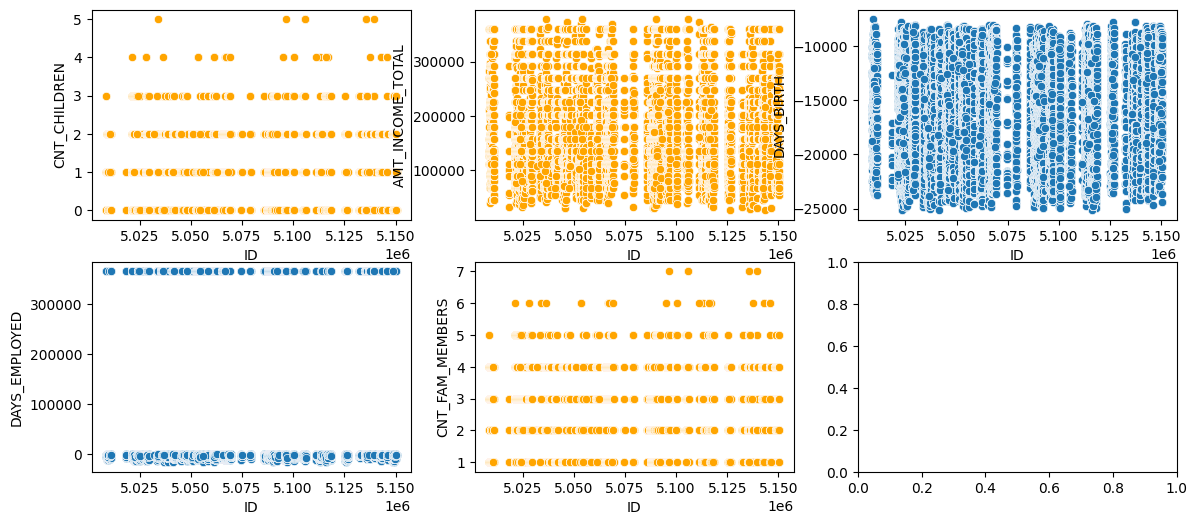

In [33]:
# Plotting post removal of outliers
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df, ax=ax[1][0])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df, ax=ax[1][1], color= 'orange')

In [35]:
df

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_PHONE,CNT_FAM_MEMBERS,STATUS,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_WORK_PHONE_1,FLAG_EMAIL_1
2,5008806,0,112500.0,2.0,4,1,1,-21474,-1134,0,2.0,0,1,1,1,0,0
3,5008808,0,270000.0,3.0,4,3,1,-19110,-3051,1,1.0,0,0,0,1,0,1
4,5008809,0,270000.0,3.0,4,3,1,-19110,-3051,1,1.0,0,0,0,1,0,1
5,5008810,0,270000.0,3.0,4,3,1,-19110,-3051,1,1.0,0,0,0,1,0,1
6,5008811,0,270000.0,3.0,4,3,1,-19110,-3051,1,1.0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,0,315000.0,2.0,4,1,1,-17348,-2420,0,2.0,0,1,1,1,0,0
434809,5149834,0,157500.0,3.0,1,1,1,-12387,-1325,1,2.0,0,0,0,1,0,1
434810,5149838,0,157500.0,1.0,1,1,1,-12387,-1325,1,2.0,0,0,0,1,0,1
434811,5150049,0,283500.0,2.0,4,1,1,-17958,-655,0,2.0,1,0,0,1,0,0


In [36]:
new_cols = [col for col in df.columns if col != 'STATUS'] + ['STATUS']
df = df[new_cols]


X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
mms = MinMaxScaler()

X_scaled = pd.DataFrame(mms.fit_transform(X_train), columns=X_train.columns)

sm = SMOTE(random_state = 42) # Re-sampling
X_train_res, y_train_res = sm.fit_resample(X_scaled, y_train)


In [37]:
X.head(2)

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_PHONE,CNT_FAM_MEMBERS,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_WORK_PHONE_1,FLAG_EMAIL_1
2,0,112500.0,2.0,4,1,1,-21474,-1134,0,2.0,1,1,1,0,0
3,0,270000.0,3.0,4,3,1,-19110,-3051,1,1.0,0,0,1,0,1


- SMOTE works by fitting the data similar to, say, SLR, then picks datapoints which lie on that line

In [41]:
y_train.value_counts()

0    27367
1      570
Name: STATUS, dtype: int64

In [42]:
np.unique(y_train_res, return_counts=True)

(array([0, 1]), array([27367, 27367]))

In [43]:
unique, counts = np.unique(y_train_res, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 27367]
 [    1 27367]]


In [44]:
classifier = DecisionTreeClassifier()
model = classifier.fit(X_train_res, y_train_res)
X_test_scaled = mms.transform(X_test)
prediction = model.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [45]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print(pd.DataFrame(confusion_matrix(y_test,prediction)))

Accuracy Score is 0.96435
      0    1
0  6698  133
1   116   38


In [46]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6831
           1       0.22      0.25      0.23       154

    accuracy                           0.96      6985
   macro avg       0.60      0.61      0.61      6985
weighted avg       0.97      0.96      0.97      6985



## Feature Importance

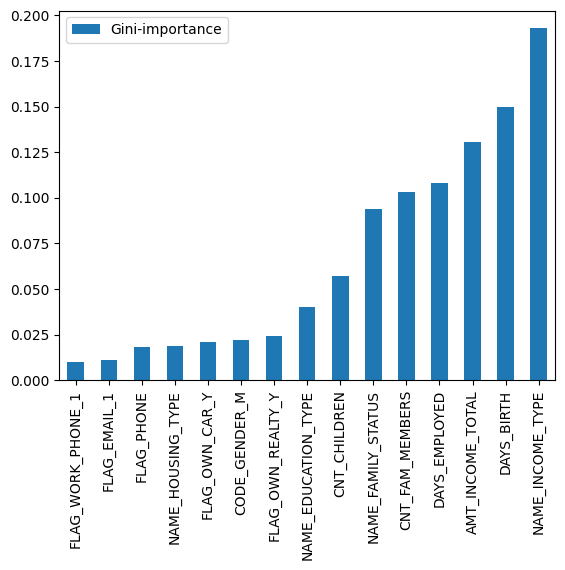

In [47]:
feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(
    by='Gini-importance').plot(
    kind='bar', rot=90)

model.feature_importances_
importances = model.feature_importances_
indices = np.argsort(importances)

In [48]:
from six import StringIO

dot_data = StringIO()

In [49]:
dot_data

In [50]:
export_graphviz(model,
                out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns,
                class_names=['0','1']
               )

In [51]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [52]:
graph.write_png('Decision_Tree.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.292497 to fit



True

# Automate ML with PyCaret

In [55]:
!pip install pycaret # Low-code ML module to train multiple models together
!pip install shap # visualize feature importance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 5.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 9

In [56]:
!pip install markupsafe==2.0.1

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.3
    Uninstalling MarkupSafe-2.1.3:
      Successfully uninstalled MarkupSafe-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
werkzeug 3.0.1 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [57]:
import pycaret

***
- Get index of all the datasets available for testing

In [58]:
from pycaret.datasets import get_data
index = get_data("index")


,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,None,None,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,None,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,None,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,None,683,10,N
6,credit,Multivariate,Classification (Binary),default,None,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,None,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,None,10000,14,N
9,employee,Multivariate,Classification (Binary),left,None,14999,10,N


In [59]:
data = get_data('juice')

,Id,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [60]:
data.shape

(1070, 19)

In [63]:
from pycaret.classification import *


In [64]:
clf1 = setup(data,
             target='Purchase',
             session_id=123,
             log_experiment=True,
             experiment_name='tds_juice',
             normalize=True,
             feature_selection=True
            )

[LightGBM] [Info] Number of positive: 292, number of negative: 457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 749, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389853 -> initscore=-0.447930
[LightGBM] [Info] Start training from score -0.447930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Description,Value
0,Session id,123
1,Target,Purchase
2,Target type,Binary
3,Target mapping,"CH: 0, MM: 1"
4,Original data shape,"(1070, 19)"
5,Transformed data shape,"(1070, 4)"
6,Transformed train set shape,"(749, 4)"
7,Transformed test set shape,"(321, 4)"
8,Ordinal features,1
9,Numeric features,17


2023/11/03 10:29:35 INFO mlflow.tracking.fluent: Experiment with name 'tds_juice' does not exist. Creating a new experiment.


In [66]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [67]:
training_data = get_config(variable="X_train")
training_data

,Id,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
584,585,264,7,1.86,2.13,0.37,0.00,1,0,0.836160,2.13,1.49,0.64,Yes,0.000000,0.198925,0.27,0
751,752,232,4,1.79,2.09,0.00,0.00,0,0,0.400000,2.09,1.79,0.30,No,0.000000,0.000000,0.30,4
462,463,228,7,1.69,1.69,0.00,0.00,0,0,0.584000,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
7,8,234,7,1.75,1.99,0.00,0.40,1,0,0.977746,1.59,1.75,-0.16,Yes,0.201005,0.000000,0.24,0
161,162,269,4,1.99,2.09,0.10,0.00,0,0,0.978010,2.09,1.89,0.20,No,0.000000,0.050251,0.10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,659,271,2,1.86,2.18,0.00,0.06,0,0,0.985493,2.12,1.86,0.26,No,0.027523,0.000000,0.32,2
390,391,236,2,1.75,1.99,0.00,0.00,0,0,0.267737,1.99,1.75,0.24,No,0.000000,0.000000,0.24,2
725,726,275,3,2.09,2.09,0.00,0.40,0,0,0.000014,1.69,2.09,-0.40,No,0.191388,0.000000,0.00,3
51,52,249,4,1.99,2.23,0.00,0.00,0,0,0.742140,2.23,1.99,0.24,No,0.000000,0.000000,0.24,4


In [68]:
training_data.shape

(749, 18)

In [69]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8092,0.8679,0.7326,0.7677,0.7486,0.5951,0.5967,0.3300
rf,Random Forest Classifier,0.8065,0.8731,0.7290,0.7641,0.7448,0.5892,0.5909,0.5280
et,Extra Trees Classifier,0.8038,0.8674,0.7120,0.7703,0.7386,0.5821,0.5845,0.4250
lightgbm,Light Gradient Boosting Machine,0.8025,0.8702,0.7189,0.7648,0.7382,0.5802,0.5835,0.4400
qda,Quadratic Discriminant Analysis,0.7985,0.8656,0.7087,0.7596,0.7319,0.5709,0.5730,0.2230
lda,Linear Discriminant Analysis,0.7985,0.8665,0.7053,0.7605,0.7310,0.5704,0.5721,0.1300
nb,Naive Bayes,0.7984,0.8656,0.7261,0.7497,0.7371,0.5737,0.5745,0.1280
ridge,Ridge Classifier,0.7971,0.0000,0.6984,0.7618,0.7279,0.5667,0.5688,0.1260
gbc,Gradient Boosting Classifier,0.7957,0.8624,0.7256,0.7470,0.7344,0.5687,0.5708,0.2340
lr,Logistic Regression,0.7931,0.8670,0.6846,0.7604,0.7198,0.5566,0.5591,0.9680


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [70]:
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [72]:
# Creating models manually
rf = create_model('rf', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7800,0.8655,0.6379,0.7551,0.6916,0.5225,0.5270
1,0.7867,0.8414,0.7241,0.7241,0.7241,0.5502,0.5502
2,0.7800,0.8526,0.6610,0.7500,0.7027,0.5292,0.5319
3,0.8333,0.8917,0.7966,0.7833,0.7899,0.6518,0.6519
4,0.8389,0.9075,0.8276,0.7742,0.8000,0.6654,0.6665
Mean,0.8038,0.8717,0.7295,0.7574,0.7417,0.5838,0.5855
Std,0.0266,0.0245,0.0738,0.0206,0.0449,0.0619,0.0608


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [73]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [74]:
# Tuning model
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7733,0.8373,0.7586,0.6875,0.7213,0.5311,0.5329
1,0.8133,0.9100,0.7241,0.7778,0.7500,0.6014,0.6023
2,0.7867,0.8846,0.8276,0.6857,0.7500,0.5668,0.5744
3,0.7867,0.8295,0.7586,0.7097,0.7333,0.5559,0.5567
4,0.7067,0.8313,0.6552,0.6129,0.6333,0.3893,0.3899
5,0.8133,0.8936,0.8276,0.7273,0.7742,0.6162,0.6200
6,0.8800,0.8988,0.9310,0.7941,0.8571,0.7548,0.7619
7,0.7867,0.8630,0.7667,0.7188,0.7419,0.5604,0.5613
8,0.8400,0.9207,0.8667,0.7647,0.8125,0.6739,0.6779


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [76]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [82]:
!pip uninstall scipy &&  pip install scipy

Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scipy-1.10.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-41284840.3.18.so
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/scipy/*
Proceed (Y/n)? y
  Successfully uninstalled scipy-1.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pycaret 3.1.0 requires scipy~=1.10.1, but you have s

In [85]:
!pip uninstall yellowbrick && pip install yellowbrick

Found existing installation: yellowbrick 1.5
Uninstalling yellowbrick-1.5:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/yellowbrick-1.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/yellowbrick/*
Proceed (Y/n)? y
  Successfully uninstalled yellowbrick-1.5
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.1.0 requires scipy~=1.10.1, but you have scipy 1.11.3 which is incompatible.


In [1]:
# Error: even on google-colab
# plot_model(tuned_rf, plot = 'confusion_matrix')


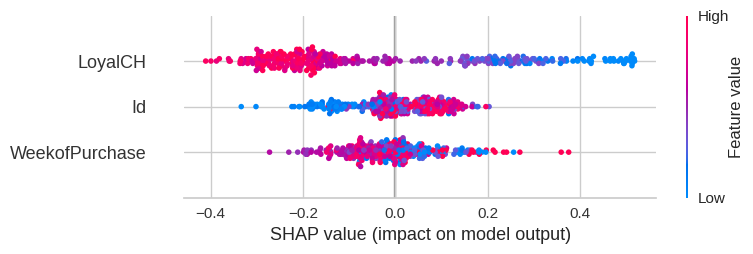

In [88]:
interpret_model(tuned_rf)

In [89]:
save_model(tuned_rf, model_name='best-model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Id', 'WeekofPurchase', 'StoreID',
                                              'PriceCH', 'PriceMM', 'DiscCH',
                                              'DiscMM', 'SpecialCH', 'SpecialMM',
                                              'LoyalCH', 'SalePriceMM',
                                              'SalePriceCH', 'PriceDi...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=None, max_

# Clustering with Python

Already studied in MLP

```python
from sklearn.cluster import KMeans
```

- Main task is the pre-processing and picking a suitable $K$ value for the number of clusters

- Elbow method, silhouette method, etc to pick a suitable $K$

- Far more important tas kfor KMeans is explaining the clusters to the clients

***

# Assignment Attempt

In [ ]:
!ls

GA_data2.csv       WEEK4b_NOTES.ipynb


![Screenshot 2023-11-02 at 7.54.08 PM.png](attachment:48e3560c-6fe9-4526-a795-463168513e8f.png)

In [ ]:
print(y_pred[284])
print(y_pred[131])
print("--------")
print(y_pred[391])
print(y_pred[316])
print("--------")
print(y_pred[115])
print(y_pred[857])
print("--------")
print(y_pred[499])
print(y_pred[280])
print("--------")

0
1
--------
3
0
--------
3
0
--------
1
1
--------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

data = pd.read_csv("GA_data2.csv", sep=",")

In [ ]:
data.head(3)

,record number,Price,Market Cap,Free Float Market Cap %,6m ADV,RoE %,RoCE %,EBIT Margin %,EPS,PAT %,Stock Return %
0,0,0.001319,0.001970,0.826221,0.021519,0.000000,0.476845,0.038117,0.000701,0.0,0.268651
1,1,0.000769,0.000579,0.441647,0.003081,0.000000,0.232072,0.000000,0.025832,0.0,0.190937
2,2,0.000132,0.000316,0.655003,0.000778,0.065568,0.000000,0.000000,0.001083,0.0,0.122265


In [ ]:
y = data.iloc[:,0]

In [ ]:
X = data.drop(['record number'], axis=1)

In [ ]:
km = KMeans(n_clusters=7, random_state=1729)

In [ ]:
y_pred = km.fit_predict(X)

/Users/PushpakRuhil/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
y_pred

array([6, 6, 6, ..., 3, 3, 1], dtype=int32)